<a href="https://colab.research.google.com/github/kevinmcmanus/lto_utils/blob/master/lto_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LTO Utilities Library

The LTO Utilities library provides a set of useful functions for dealing with files output from the Little Thompson Observatory's radio telescope. These files, suffixed with '.lto' capture spectral information and the data processing pipeline produces them at approximately one-minute intervals throughout an observation.

For the purposes of this demo, a 24-hour drift scan observation is available in Google Cloud Storage.  Having the data in GCS complicates this demo somewhat in that the Google Colab virtual machine that is running this notebook needs to mount the GCS as a preliminary step.
The actual demonstration of obtaining and using the `lto_utils` library begins in the section entitled 'Clone the lto_utils' repo.

## Preliminaries

### References on Using Cloud Storage in Colab

These articles explain how to make Google Cloud Storage availabale within a Google Colab notebook, such as this one.

(https://medium.com/analytics-vidhya/how-to-access-files-from-google-cloud-storage-in-colab-notebooks-8edaf9e6c020)

(https://stackoverflow.com/questions/51715268/how-to-import-data-from-google-cloud-storage-to-google-colab)

(https://ostrokach.gitlab.io/post/google-colab-storage/)

### Authenticate and Mount GCS Bucket

In [1]:
#from google.colab import auth

#auth.authenticate_user()

In [2]:
#!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
#!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
#!sudo apt -qq update
#!sudo apt -qq install gcsfuse

In [3]:
#Mount the drive
#!mkdir lto_data
#!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 lto_data lto_data

## Clone the lto_utils Repo

In [4]:
#!git clone https://github.com/kevinmcmanus/lto_utils

In [5]:
import sys
sys.path.append('lto_utils')

In [6]:
from lto_file import LTO_File, getDriftScan, getSpectralCharacteristics, getLTOobs

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

## Read Single LTO File and Examine its Contents

In [8]:
#lto/lto_data.old/2020_05_01/LTO-Cygnus-2020-05-01-12-28-59.lto

obs_dir = '../local_data' # dir where the observations live
obs_date = '2020_08_10' # dir of the day's observations
obs_file = 'LTO-SRGA-2020-08-10-03-43-50.lto' #a particular minute's observation

In [9]:
#create an LTO_File object and read its contents
lto_file = LTO_File(os.path.join(obs_dir, obs_date, obs_file))

In [10]:
print(lto_file)


LTO File; Obs Time: 2020-08-10 03:43:50 UT, Az: 180.00, El: 23.90, RA: 18.00, Dec: -25.80, from file: ../local_data/2020_08_10/LTO-SRGA-2020-08-10-03-43-50.lto


In [11]:
lto_file

LTO File; Obs Time: 2020-08-10 03:43:50 UT, Az: 180.00, El: 23.90, RA: 18.00, Dec: -25.80, from file: ../local_data/2020_08_10/LTO-SRGA-2020-08-10-03-43-50.lto

## SpectralHeader and SpectralData

`lto_file` object contains two attributes: `SpectralHeader` and `SpectralData`. Both are large data structures. The `SpectralHeader` has several subsections which are:

In [12]:
lto_file.SpectralHeader.keys()

dict_keys(['Magic', 'Observatory', 'ObsLocation', 'BeamPosition', 'ObsTime', 'Spectrum', 'RadioCalibrations', 'ProgramControl', 'SpectralCharacteristics'])

 
The subsection `SpectralCharacteristics`  contains summary information of the file. 
 This subsection is particularly useful.

In [13]:
lto_file.SpectralHeader['SpectralCharacteristics']

{'avespecpwr': 1.572542423211468e-21,
 'varspecpwr': 5.76376387243824e-45,
 'totalpwr': 1.973068978403424e-17,
 'numspecpwr': 12547,
 'numave': 26201,
 'numbad': 11,
 'aveindvpwr': 0.0018574740970507264,
 'varindvpwr': 2.7688751291776725e-10,
 'peakpwr': 2.1604689363984977e-21,
 'peakpwrfreq': 1420340993.1875,
 'totalHIpwr': 1.2881637714824599e-18,
 'numHIpwr': 706,
 'avecrpwr': 1.5575142312770697e-21,
 'varcrpwr': 2.700992399731862e-46,
 'numcrpwr': 11841,
 'avetsky': 112.81033325195312,
 'vartsky': 1.4169583955157339,
 'peaktsky': 156.4821824745445,
 'peaktskyfreq': 1420340993.1875,
 'avefluxden': 23125.62322210062,
 'varfluxden': 1246488.6814920532,
 'peakfluxden': 31771.601114690853,
 'peakfluxfreq': 1420340993.1875,
 'badspec': False,
 'processing': 'Raw FFT',
 'user': ''}

Meta data about the spectrum is captured in the `SpectralHeader['Spectrum']` dictionary element:

In [14]:
lto_file.SpectralHeader['Spectrum']

{'samplerate': 10000000.0,
 'wordformat': 0,
 'numchannels': 2,
 'lenfft': 16384,
 'numspec': 1,
 'period': 0.001638400019146502,
 'dfs': 610.3515625,
 'cf': 1419398000.0,
 'nenbw': 1.0,
 'enbw': 610.3515625,
 'ws1': 1.0,
 'ws2': 16384.0,
 'dt': 42.94573974609375,
 'flow': -4000000.0,
 'fhigh': 3700000.0,
 'ndlow': -6553,
 'ndhigh': 6062,
 'user3': ''}

`SpectralData` is a  dictionary which captures the spectrum and some other Dopler frequency-dependent measures.  Each dictionary element is a vector of length `SpectralHeader['Spectrum']['lenfft']+1`. (+1 to account for the center frequency (Dopler frequency=0.0) which isn't usually counted in the fft length)

In [15]:
# the spectral data vectors:
lto_file.SpectralData.keys()

dict_keys(['dopfreq', 'rawavepwr', 'rawvarpwr', 'calavepwr', 'flatten', 'tsky', 'fluxden', 'badline', 'HIline'])

In [16]:
'Length of FFT: {}, Length of tsky vector: {}, Length of fluxden vector: {}'.format(
        lto_file.SpectralHeader['Spectrum']['lenfft'],
        len(lto_file.SpectralData['tsky']),
        len(lto_file.SpectralData['fluxden']))

'Length of FFT: 16384, Length of tsky vector: 16385, Length of fluxden vector: 16385'

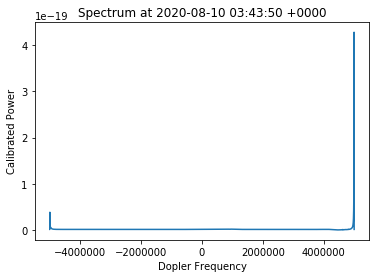

In [17]:
plt.plot(lto_file.SpectralData['dopfreq'], lto_file.SpectralData['calavepwr'])
plt.xlabel('Dopler Frequency')
plt.ylabel('Calibrated Power')

zz=plt.title('Spectrum at '+lto_file.get_time().strftime('%Y-%m-%d %H:%M:%S %z'))

## Clipping the Spectrum

LTO Spectra often have spurious data at either extreme as graph above shows. The `LTO_File` class provides a clipping method allowing extraction of spectral data from arbitrary regions of the spectrum.

The `.dfclipper()` method a low frequency and high frequency -- both Dopler offsets and both in Hertz and returns a `slice` object.
The object can then be used to slice any of the `SpectralData` vectors as follows:

In [18]:
# get a slicer to extract spectral data offset between 250KHz and 1750KHz
s = lto_file.dfclipper(dfclip = (.25e6, 1.75e6))
print(f'Clipper returned: {s}')

Clipper returned: slice(8601, 11061, None)


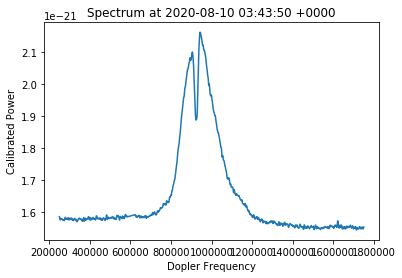

In [19]:
# use the slicer from above to slice the dopfreq and calavepwr vectors:
plt.plot(lto_file.SpectralData['dopfreq'][s], lto_file.SpectralData['calavepwr'][s])
plt.xlabel('Dopler Frequency')
plt.ylabel('Calibrated Power')

zz=plt.title('Spectrum at '+lto_file.get_time().strftime('%Y-%m-%d %H:%M:%S %z'))

## Spectral Data as Pandas `Data.Frame`

Sometimes it's convenient to work with the `SpectralData` as  a `Pandas` dataframe. The `LTO_File` class provides a method to do so.

In [20]:
import pandas as pd
pd_df = lto_file.to_pandas()
pd_df.head()

,ts,ra,dec,dopfreq,rawavepwr,rawvarpwr,calavepwr,flatten,tsky,fluxden,badline,HIline
0,2020-08-10 03:43:50+00:00,18.002216,-25.800467,-5000000.0,0.001857,2.768875e-10,1.579388e-21,0.000000,114.394646,23226.292969,True,False
1,2020-08-10 03:43:50+00:00,18.002216,-25.800467,-4999389.5,0.001857,2.768875e-10,1.579388e-21,0.000000,114.394646,23226.292969,True,False
2,2020-08-10 03:43:50+00:00,18.002216,-25.800467,-4998779.5,0.134270,1.783956e-02,2.306548e-20,44.365669,1670.626465,339198.218750,True,False
3,2020-08-10 03:43:50+00:00,18.002216,-25.800467,-4998169.0,0.073415,5.367959e-03,3.440993e-20,24.306440,2492.302002,506028.406250,True,False
4,2020-08-10 03:43:50+00:00,18.002216,-25.800467,-4997558.5,0.049789,2.529974e-03,3.861341e-20,16.588919,2796.759277,567844.312500,True,False


## Read All LTO Files in a Directory

`lto_utils` provides functionality to read all `.lto` in a directory. This can useful in summarizing an observing session, such as a drift scan.

**Caution:** the methods below will read **all** `.lto` files in the specified directory, so if there are files with duplicate content or `.lto` files from other observing sessions, such files will contaminate the results.

In [21]:
#Routtines for dealing with all of the observations in a directory:
from lto_file import getDriftScan, getSpectralCharacteristics, getLTOobs

# to loop over the files and do something with each (here we'll just get the first five and print them)
for i, lto in enumerate(getLTOobs(os.path.join(obs_dir, obs_date))):
    if i >= 5:
        break
    print (lto)

LTO File; Obs Time: 2020-08-10 00:34:00 UT, Az: 180.00, El: 23.90, RA: 14.83, Dec: -25.80, from file: ../local_data/2020_08_10/LTO-SRGA-2020-08-10-00-34-00.lto
LTO File; Obs Time: 2020-08-10 00:34:53 UT, Az: 180.00, El: 23.90, RA: 14.84, Dec: -25.80, from file: ../local_data/2020_08_10/LTO-SRGA-2020-08-10-00-34-53.lto
LTO File; Obs Time: 2020-08-10 00:35:47 UT, Az: 180.00, El: 23.90, RA: 14.86, Dec: -25.80, from file: ../local_data/2020_08_10/LTO-SRGA-2020-08-10-00-35-47.lto
LTO File; Obs Time: 2020-08-10 00:36:42 UT, Az: 180.00, El: 23.90, RA: 14.87, Dec: -25.80, from file: ../local_data/2020_08_10/LTO-SRGA-2020-08-10-00-36-42.lto
LTO File; Obs Time: 2020-08-10 00:37:40 UT, Az: 180.00, El: 23.90, RA: 14.89, Dec: -25.80, from file: ../local_data/2020_08_10/LTO-SRGA-2020-08-10-00-37-40.lto


In [22]:
#get all the spectral characteristics for the observation of obs_date
# this can take a several minutes to run, espcially if the files are not local
obs_summary = getSpectralCharacteristics(os.path.join(obs_dir, obs_date))

obs_summary.head()

,ra,dec,avespecpwr,varspecpwr,totalpwr,numspecpwr,numave,numbad,aveindvpwr,varindvpwr,...,vartsky,peaktsky,peaktskyfreq,avefluxden,varfluxden,peakfluxden,peakfluxfreq,badspec,processing,user
2020-08-10 00:34:00+00:00,14.829665,-25.800467,1.455268e-21,2.139275e-46,1.825925e-17,12547,26200,20,0.001719,2.388994e-10,...,0.613265,113.363226,1.420303e+09,21400.998798,46264.587639,23016.877233,1.420303e+09,False,Raw FFT,
2020-08-10 00:34:53+00:00,14.844427,-25.800467,1.456044e-21,2.158379e-46,1.827044e-17,12548,26211,9,0.001720,2.386217e-10,...,0.614103,113.198137,1.420308e+09,21412.412698,46677.749747,22983.358256,1.420308e+09,False,Raw FFT,
2020-08-10 00:35:47+00:00,14.859468,-25.800467,1.456375e-21,2.217437e-46,1.827314e-17,12547,26214,6,0.001720,2.401903e-10,...,0.628941,113.219749,1.420309e+09,21417.285760,47954.944830,22987.746179,1.420309e+09,False,Raw FFT,
2020-08-10 00:36:42+00:00,14.874788,-25.800467,1.455981e-21,2.249310e-46,1.826674e-17,12546,26252,8,0.001720,2.396765e-10,...,0.633217,113.558702,1.420308e+09,21411.491215,48644.253662,23056.566031,1.420308e+09,False,Raw FFT,
2020-08-10 00:37:40+00:00,14.890944,-25.800467,1.454406e-21,2.287815e-46,1.824843e-17,12547,26230,2,0.001718,2.388391e-10,...,0.630084,113.391653,1.420307e+09,21388.324849,49476.972604,23022.649097,1.420307e+09,False,Raw FFT,


In [23]:
len(obs_summary)

400

### Make a Plot

In [24]:
#helper routine to beautify the time formating in the following plots:
import matplotlib.dates as mdates
fmt = mdates.DateFormatter('%H:%M')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Text(0.5, 1.0, 'Sky Temperature, Drift Scan 2020_08_10')

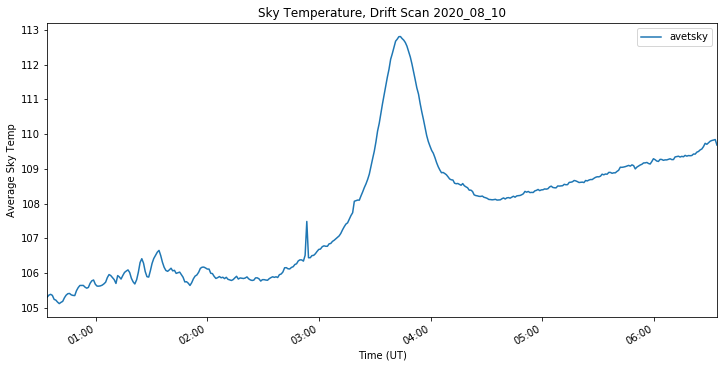

In [25]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()

#use panda's builtin plot routine
obs_summary.plot(y='avetsky', ax=ax)

#annotate the axes
ax.xaxis.set_major_formatter(fmt)
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Average Sky Temp')
ax.set_title(f'Sky Temperature, Drift Scan {obs_date}')

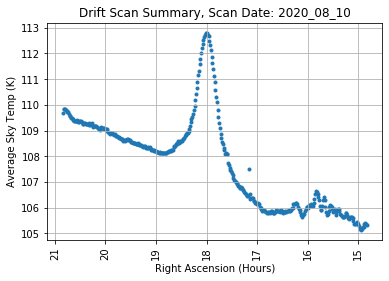

In [26]:
#it's a drift scan so plot by right ascension
plt.scatter(obs_summary.ra, obs_summary.avetsky, s=9)
plt.title(f'Drift Scan Summary, Scan Date: {obs_date}')
plt.xlabel('Right Ascension (Hours)')
plt.xticks(rotation=90)
plt.ylabel('Average Sky Temp (K)')
plt.grid()
plt.gca().invert_xaxis()

In [27]:
#get all the spectral data from the drift scan
spectra = getDriftScan(os.path.join(obs_dir, obs_date))

In [28]:
spectra.head()

,ts,ra,dec,dopfreq,rawavepwr,rawvarpwr,calavepwr,flatten,tsky,fluxden,badline,HIline
0,2020-08-10 00:34:00+00:00,14.829665,-25.800467,-5000000.0,0.001719,2.388994e-10,1.448165e-21,0.000000,104.890182,21296.541016,True,False
1,2020-08-10 00:34:00+00:00,14.829665,-25.800467,-4999389.5,0.001719,2.388994e-10,1.448165e-21,0.000000,104.890182,21296.541016,True,False
2,2020-08-10 00:34:00+00:00,14.829665,-25.800467,-4998779.5,0.124052,1.553360e-02,2.143267e-20,44.365669,1552.362549,315186.312500,True,False
3,2020-08-10 00:34:00+00:00,14.829665,-25.800467,-4998169.0,0.068313,4.728796e-03,3.199719e-20,24.306440,2317.548096,470546.968750,True,False
4,2020-08-10 00:34:00+00:00,14.829665,-25.800467,-4997558.5,0.046860,2.194188e-03,3.593004e-20,16.588919,2602.402832,528382.875000,True,False


Yeilds a rather large data frame:

In [29]:
len(spectra)

6554000

## Construct a Spectrogram

The `spectra` data frame from above can be unweildy with 23 million rows, so the `getDriftScan` method provides a `dfclip` method to eliminate data at the far ends of the spectrum. If we clip the spectrum, the production of the spectrogram proceeds much faster.

In [30]:
#clip to 250kHz to 1750 kHz
spectra = getDriftScan(os.path.join(obs_dir, obs_date), dfclip = (.25e6, 1.75e6))
len(spectra)

983200

In [31]:
#make the temperature array dopfreq x time

#sort the spectra data frame
spectra.sort_values(['dopfreq', 'ts'], inplace=True)

#get the y axis (dopler freq) values: (relies on unique() returning in ascending order)
dopfreqs = spectra.dopfreq.unique()

# next, get the x-axis which is the time of the observations;
obs_times = spectra.ts.unique()

#make the temperature array
skytemp = np.array(spectra.tsky).reshape(len(dopfreqs), len(obs_times))

skytemp.shape

(2458, 400)

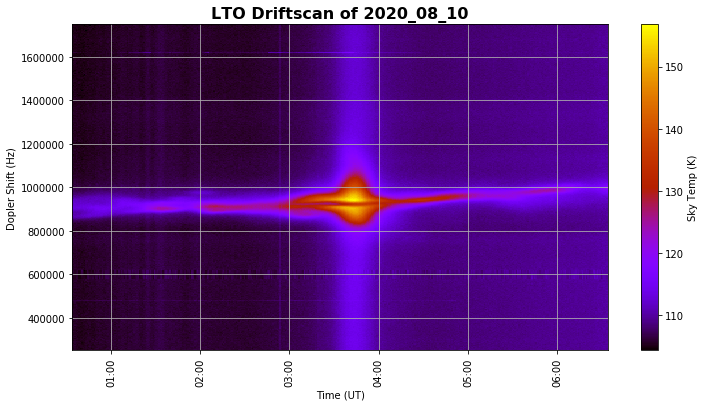

In [33]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()

pcm = ax.pcolormesh(obs_times, dopfreqs, skytemp,cmap='gnuplot')

fig.colorbar(pcm, label='Sky Temp (K)')

plt.xlabel('Time (UT)')
plt.gca().xaxis.set_major_formatter(fmt)
plt.xticks(rotation=90)
plt.ylabel('Dopler Shift (Hz)')
plt.title(f'LTO Driftscan of {obs_date}',fontdict={'fontsize':16, 'fontweight':'bold'})
plt.grid()